In [1]:
import pandas as pd
import numpy as np

## Load Data

In [2]:
delay = pd.read_csv("Airline_Delay_Cause.csv")
weather = pd.read_csv("3988168.csv")

## CLEANING 

In [3]:
delay['date'] = pd.to_datetime(
    delay[['year', 'month']].assign(day=1)
)

delay['delay_rate'] = delay['arr_del15'] / delay['arr_flights']

# Create a reliability metric
delay['airport_reliability_index'] = (
    1 - delay['delay_rate']
) * 100
# Higher values indicate better reliability 
# (i.e., fewer delays)


In [4]:
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather['month'] = weather['DATE'].dt.month
weather['year'] = weather['DATE'].dt.year

# Monthly averages
weather_monthly = weather.groupby(['year','month'], as_index=False).agg({
    'AWND':'mean',
    'PRCP':'sum',
    'TMAX':'mean',
    'TMIN':'mean'
})

# Weather severity score
weather_monthly['temp_variation'] = weather_monthly['TMAX'] - weather_monthly['TMIN']

weather_monthly['weather_severity_score'] = (
    0.4 * weather_monthly['PRCP'] +
    0.3 * weather_monthly['AWND'] +
    0.3 * weather_monthly['temp_variation']
)
# Lower values indicate milder weather conditions
# Higher values indicate more severe weather conditions


## MERGE DATASET

In [5]:
merged = pd.merge(
    delay,
    weather_monthly,
    on=['year','month'],
    how='left'
)

## FEATURE ENGINERING

In [7]:
merged['delay_risk_score'] = (
    0.5 * merged['delay_rate'] +
    0.3 * merged['weather_severity_score'] +
    0.2 * merged['late_aircraft_ct']
)

# Target variable
merged['label_delay_high'] = (merged['arr_delay'] > merged['arr_delay'].median()).astype(int)



## MODEL TRAINING

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

features = [
    'delay_rate', 'weather_severity_score', 'airport_reliability_index',
    'carrier_ct','weather_ct','nas_ct','late_aircraft_ct','delay_risk_score'
]

X = merged[features].fillna(0)
y = merged['label_delay_high']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

model = RandomForestClassifier(n_estimators=300)

In [9]:
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300)

In [10]:
pred = model.predict(X_test)

In [11]:
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

Accuracy: 0.9727891156462585
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        82
           1       0.97      0.97      0.97        65

    accuracy                           0.97       147
   macro avg       0.97      0.97      0.97       147
weighted avg       0.97      0.97      0.97       147



In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

## Monthly Delay Rate Trend

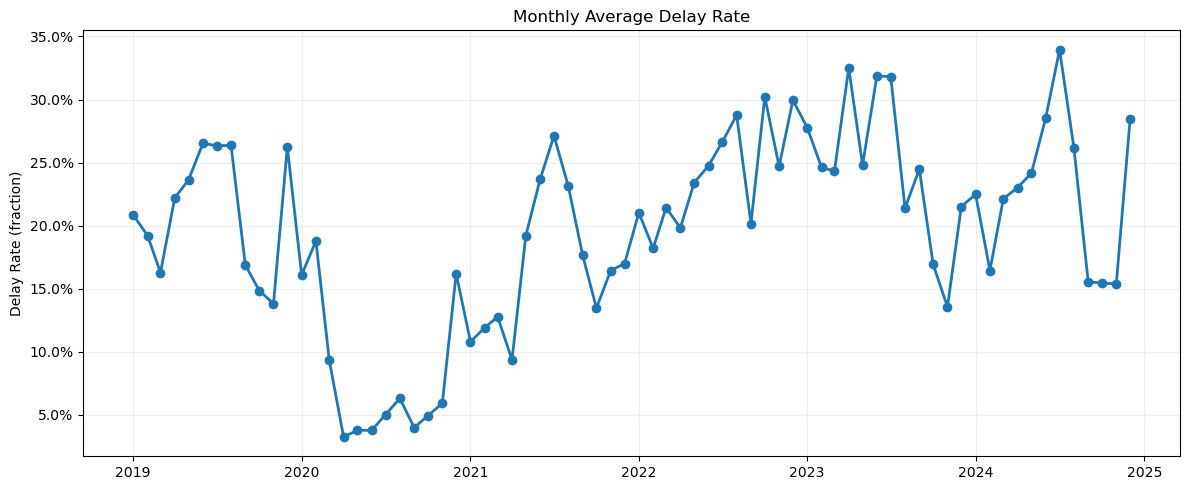

In [13]:
plt.figure(figsize=(12,5))
grp = merged.groupby(['year','month']).agg(delay_rate=('delay_rate','mean')).reset_index()
grp['ym'] = pd.to_datetime(grp.assign(day=1)[['year','month','day']])
plt.plot(grp['ym'], grp['delay_rate'], marker='o', linewidth=2)
plt.title('Monthly Average Delay Rate')
plt.ylabel('Delay Rate (fraction)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


## Delay Cause Distribution

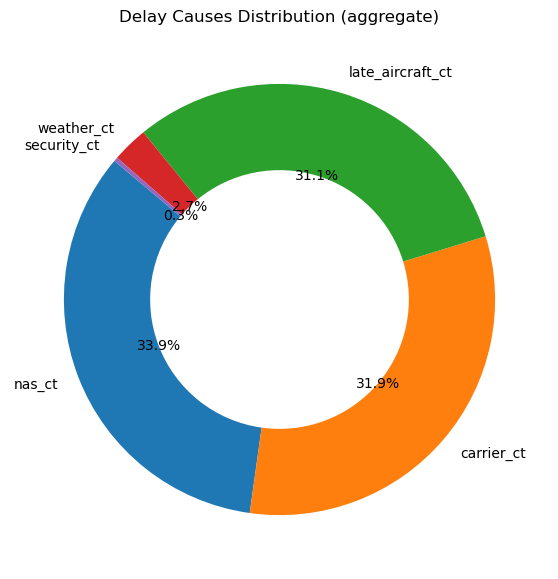

In [14]:
# aggregate causes
causes = ['carrier_ct','weather_ct','nas_ct','security_ct','late_aircraft_ct']
cause_sum = merged[causes].sum().sort_values(ascending=False)
plt.figure(figsize=(7,7))
plt.pie(cause_sum, labels=cause_sum.index, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4))
plt.title('Delay Causes Distribution (aggregate)')
plt.show()

## Airport Reliability Index Over Time

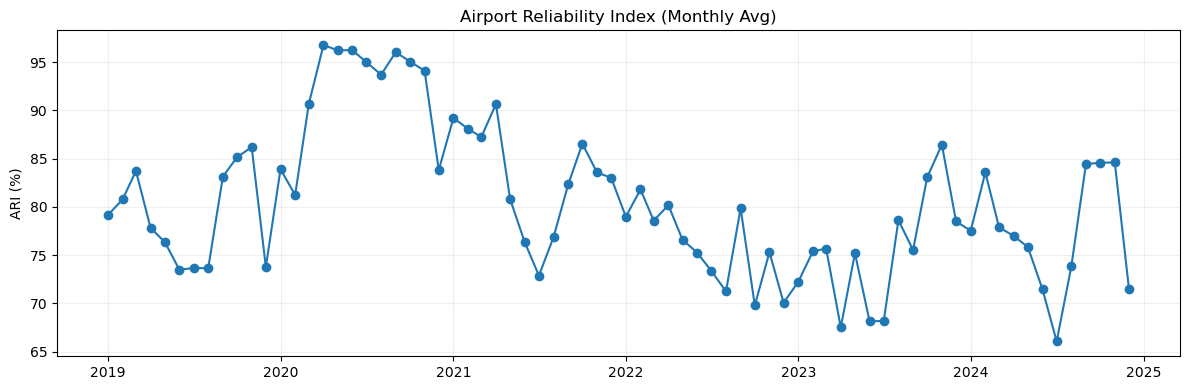

In [15]:
if 'airport_reliability_index' in merged.columns:
    ari = merged.groupby(['year','month'])['airport_reliability_index'].mean().reset_index()
    ari['ym'] = pd.to_datetime(ari.assign(day=1)[['year','month','day']])
    plt.figure(figsize=(12,4))
    plt.plot(ari['ym'], ari['airport_reliability_index'], marker='o')
    plt.title('Airport Reliability Index (Monthly Avg)')
    plt.ylabel('ARI (%)')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

## Monthly Precipitation vs Delay Rate

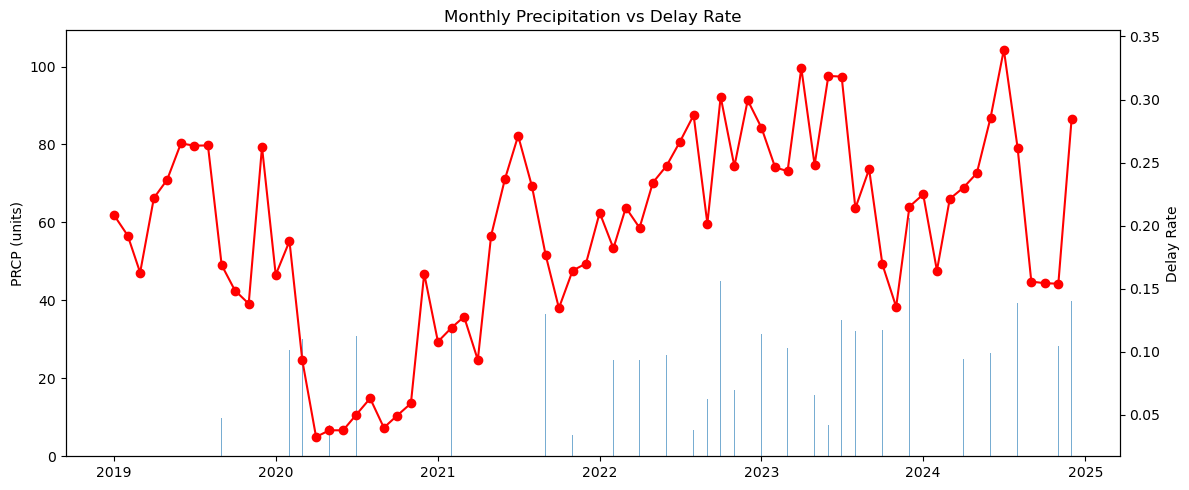

In [16]:
if 'PRCP' in merged.columns:
    m = merged.groupby(['year','month']).agg(PRCP=('PRCP','sum'), delay_rate=('delay_rate','mean')).reset_index()
    m['ym'] = pd.to_datetime(m.assign(day=1)[['year','month','day']])
    fig, ax1 = plt.subplots(figsize=(12,5))
    ax1.bar(m['ym'], m['PRCP'], alpha=0.6, label='Monthly PRCP (sum)')
    ax1.set_ylabel('PRCP (units)')
    ax2 = ax1.twinx()
    ax2.plot(m['ym'], m['delay_rate'], color='red', marker='o', label='Delay Rate')
    ax2.set_ylabel('Delay Rate')
    ax1.set_title('Monthly Precipitation vs Delay Rate')
    fig.tight_layout()
    plt.show()

## Feature Importance

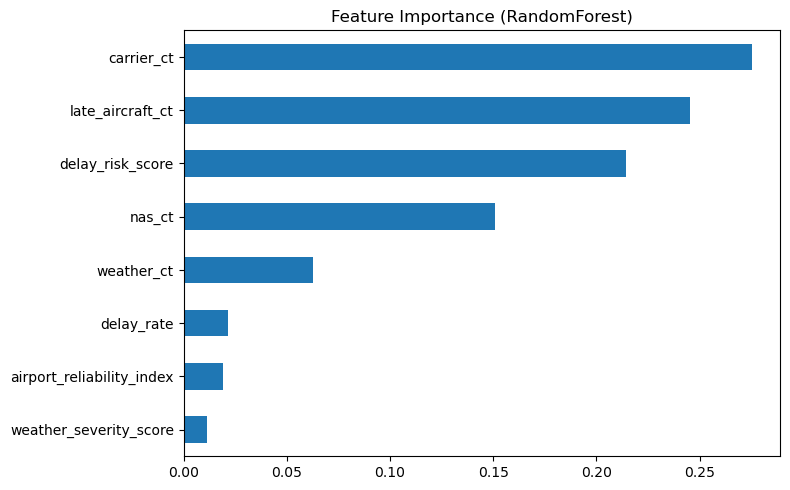

In [17]:
# If you have a trained sklearn model named `model` and a feature list `features`
try:
    feature_names = features  # list of column names used in model
    importances = model.feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values()
    plt.figure(figsize=(8,5))
    fi.plot(kind='barh')
    plt.title('Feature Importance (RandomForest)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Feature importance plot skipped (need trained sklearn model and feature list).", e)